In [ ]:
import marimo as mo

# 栄養問題

- 定数
  - $F$: 商品の集合
  - $N$: 栄養素の集合
  - $a_i$: 栄養素 $i$ の 1 日の摂取量の下限
  - $b_i$: 栄養素 $i$ の 1 日の摂取量の上限
  - $c_j$: 商品 $j$ の価格
  - $n_{ij}$: 商品 $j$ に含まれる栄養素 $i$ の量
- 決定変数
  - $x_j \in \mathbb{R}_{\geq 0}$: 商品 $j$ を購入する個数

\begin{align}
&\text{minimize} & \sum_{j \in F} c_j x_j \\
&\text{s.t.} & a_i \leq \sum_{j \in F} n_{ij} x_j \leq b_i \ (\forall i \in N) \\
& & x_j \geq 0 \ (\forall j \in F)
\end{align}

In [ ]:
from ortools.math_opt.python import mathopt
import pyscipopt
import pandas as pd

## 実行不能のケース

\begin{align}
&\text{maximize} & x_1 + x_2 \\
&\text{s.t.} & x_1 - x_2 \leq -1 \\
& & - x_1 + x_2 \leq -1 \\
& & x_1, x_2 \geq 0
\end{align}

In [ ]:
_model = mathopt.Model()
_x1 = _model.add_variable(lb=0)
_x2 = _model.add_variable(lb=0)

_model.add_linear_constraint(_x1 - _x2 <= -1)
_model.add_linear_constraint(-_x1 + _x2 <= -1)

_model.maximize(_x1 + _x2)

_params = mathopt.SolveParameters(enable_output=True)
_result = mathopt.solve(_model, mathopt.SolverType.HIGHS, params=_params)

_result.termination.reason

LP   has 2 rows; 2 cols; 4 nonzeros
Coefficient ranges:
  Matrix [1e+00, 1e+00]
  Cost   [1e+00, 1e+00]
  Bound  [0e+00, 0e+00]
  RHS    [1e+00, 1e+00]
Presolving model
2 rows, 2 cols, 4 nonzeros  0s
Problem status detected on presolve: Infeasible
Model status        : Infeasible
Objective value     :  0.0000000000e+00
HiGHS run time      :          0.00


## 非有界のケース

\begin{align}
&\text{maximize} & x_1 + x_2 \\
&\text{s.t.} & x_1 - x_2 \geq -1 \\
& & - x_1 + x_2 \geq -1 \\
& & x_1, x_2 \geq 0
\end{align}

In [ ]:
_model = mathopt.Model()
_x1 = _model.add_variable(lb=0)
_x2 = _model.add_variable(lb=0)

_model.add_linear_constraint(_x1 - _x2 >= -1)
_model.add_linear_constraint(-_x1 + _x2 >= -1)

_model.maximize(_x1 + _x2)

_params = mathopt.SolveParameters(enable_output=True)
_result = mathopt.solve(_model, mathopt.SolverType.HIGHS, params=_params)

_result.termination.reason

LP   has 2 rows; 2 cols; 4 nonzeros
Coefficient ranges:
  Matrix [1e+00, 1e+00]
  Cost   [1e+00, 1e+00]
  Bound  [0e+00, 0e+00]
  RHS    [1e+00, 1e+00]
Presolving model
2 rows, 2 cols, 4 nonzeros  0s
Problem status detected on presolve: Primal infeasible or unbounded
Solving the original LP with primal simplex to determine infeasible or unbounded
Using EKK primal simplex solver
  Iteration        Objective     Infeasibilities num(sum)
          0    -5.3672046609e-07 Pr: 0(0); Du: 2(2) 0s
          1     1.0000000000e+00 Pr: 0(0); Du: 1(2) 0s
Model status        : Unbounded
Simplex   iterations: 1
Objective value     :  1.0000000000e+00
Relative P-D gap    :  0.0000000000e+00
HiGHS run time      :          0.00


## 実行不可能性の対処法(制約の逸脱を許すモデル化)

栄養素摂取量制約の逸脱を許すために摂取量の不足分と超過分を表す決定変数を用意する.

- $d_i \in \mathbb{R}_{\geq 0}$: 栄養素 $i$ に対する不足変数
- $s_i \in \mathbb{R}_{\geq 0}$: 栄養素 $i$ に対する超過変数

制約を以下のように変更する.

$$
a_i - d_i \leq \sum_{j \in F} n_{ij} x_j \leq b_i + s_i \ (\forall i \in N)
$$

目的関数には以下の逸脱ペナルティを追加する($M$ は十分大きな定数).

$$
\text{minimize} \sum_{j \in F} c_j x_j + M \sum_{i \in N} (d_i + s_i)
$$

結果, 以下のような定式化になる.

\begin{align}
&\text{minimize} & \sum_{j \in F} c_j x_j + M \sum_{i \in N} (d_i + s_i) \\
&\text{s.t.} & a_i - d_i \leq \sum_{j \in F} n_{ij} x_j \leq b_i + s_i \ (\forall i \in N) \\
& & x_j \geq 0 \ (\forall j \in F)
\end{align}

In [ ]:
# https://scmopt.github.io/manual/15mypulp.html#multidict%E9%96%A2%E6%95%B0


def multidict(d: dict):
    ret = [list(d.keys())]
    for k, arr in d.items():
        if type(arr) is not list:
            arr = [arr]
        append_num = 1 + len(arr) - len(ret)
        if append_num > 0:
            ret = ret + [{} for _ in range(append_num)]
        for i, val in enumerate(arr):
            ret[i + 1][k] = val
    return ret

In [ ]:
_I, _d = multidict({1: 80, 2: 270, 3: 250, 4: 160, 5: 180})
_J, _M, _N = multidict({1: [500, 600], 2: [800, 500], 3: [500, 100]})
print(_I, _d)
print(_J, _M, _N)

[1, 2, 3, 4, 5] {1: 80, 2: 270, 3: 250, 4: 160, 5: 180}
[1, 2, 3] {1: 500, 2: 800, 3: 500} {1: 600, 2: 500, 3: 100}


In [ ]:
F, c, n = multidict(
    {
        "CQPounder": [
            360,
            {
                "Cal": 556,
                "Carbo": 39,
                "Protein": 30,
                "VitA": 147,
                "VitC": 10,
                "Calc": 221,
                "Iron": 2.4,
            },
        ],
        "Big M": [
            320,
            {
                "Cal": 556,
                "Carbo": 46,
                "Protein": 26,
                "VitA": 97,
                "VitC": 9,
                "Calc": 142,
                "Iron": 2.4,
            },
        ],
        "FFilet": [
            270,
            {
                "Cal": 356,
                "Carbo": 42,
                "Protein": 14,
                "VitA": 28,
                "VitC": 1,
                "Calc": 76,
                "Iron": 0.7,
            },
        ],
        "Chicken": [
            290,
            {
                "Cal": 431,
                "Carbo": 45,
                "Protein": 20,
                "VitA": 9,
                "VitC": 2,
                "Calc": 37,
                "Iron": 0.9,
            },
        ],
        "Fries": [
            190,
            {
                "Cal": 249,
                "Carbo": 30,
                "Protein": 3,
                "VitA": 0,
                "VitC": 5,
                "Calc": 7,
                "Iron": 0.6,
            },
        ],
        "Milk": [
            170,
            {
                "Cal": 138,
                "Carbo": 10,
                "Protein": 7,
                "VitA": 80,
                "VitC": 2,
                "Calc": 227,
                "Iron": 0,
            },
        ],
        "VegJuice": [
            100,
            {
                "Cal": 69,
                "Carbo": 17,
                "Protein": 1,
                "VitA": 750,
                "VitC": 2,
                "Calc": 18,
                "Iron": 0,
            },
        ],
    }
)

In [ ]:
N, a, b = multidict(
    {
        "Cal": [2000, 3000],
        "Carbo": [300, 375],
        "Protein": [50, 60],
        "VitA": [500, 750],
        "VitC": [85, 100],
        "Calc": [660, 900],
        "Iron": [6.0, 7.5],
    }
)

In [ ]:
model0 = mathopt.Model()

x1 = {_j: model0.add_variable(lb=0.0, name=f"x[{_j}]") for _j in F}
s1 = {_i: model0.add_variable(lb=0.0, name=f"s[{_i}]") for _i in N}
d1 = {_i: model0.add_variable(lb=0.0, name=f"d[{_i}]") for _i in N}

for _i in N:
    model0.add_linear_constraint(
        sum((n[_j][_i] * x1[_j] for _j in F)) >= a[_i] - d1[_i]
    )
    model0.add_linear_constraint(
        sum((n[_j][_i] * x1[_j] for _j in F)) <= b[_i] - s1[_i]
    )

_M = 9999
_objective = sum((c[_j] * x1[_j] for _j in F)) + _M * sum(
    (d1[_i] + s1[_i] for _i in N)
)
model0.minimize(_objective)

_params = mathopt.SolveParameters(enable_output=True)
result1 = mathopt.solve(model0, mathopt.SolverType.GSCIP, params=_params)
if result1.termination.reason != mathopt.TerminationReason.OPTIMAL:
    raise RuntimeError(f"model failed to solve: {result1.termination}")

presolving:
(round 1, fast)       7 del vars, 0 del conss, 0 add conss, 15 chg bounds, 0 chg sides, 0 chg coeffs, 0 upgd conss, 0 impls, 0 clqs
(round 2, fast)       7 del vars, 0 del conss, 0 add conss, 22 chg bounds, 0 chg sides, 0 chg coeffs, 0 upgd conss, 0 impls, 0 clqs
   Deactivated symmetry handling methods, since SCIP was built without symmetry detector (SYM=none).
   Deactivated symmetry handling methods, since SCIP was built without symmetry detector (SYM=none).
presolving (3 rounds: 3 fast, 1 medium, 1 exhaustive):
 7 deleted vars, 0 deleted constraints, 0 added constraints, 22 tightened bounds, 0 added holes, 0 changed sides, 0 changed coefficients
 0 implications, 0 cliques
presolved problem has 14 variables (0 bin, 0 int, 0 impl, 14 cont) and 14 constraints
     14 constraints of type <linear>
Presolving Time: 0.00

 time | node  | left  |LP iter|LP it/n|mem/heur|mdpt |vars |cons |rows |cuts |sepa|confs|strbr|  dualbound   | primalbound  |  gap   | compl. 
* 0.0s|     1 

In [ ]:
x1val = {_j: result1.variable_values()[x1[_j]] for _j in F}
s1val = {_i: result1.variable_values()[s1[_i]] for _i in N}
d1val = {_i: result1.variable_values()[d1[_i]] for _i in N}

for _i in N:
    _info = "正常"
    if (
        sum(n[_j][_i] * x1val[_j] for _j in F) < a[_i] - d1val[_i]
        or sum(n[_j][_i] * x1val[_j] for _j in F) > b[_i] - s1val[_i]
    ):
        _info = "違反"
    print(
        f"[{_info}]栄養素 {_i:<7} 摂取量 {sum(n[_j][_i] * x1val[_j] for _j in F):>7.2f}, 正常範囲: [{a[_i]:>6.1f}, {b[_i]:>6.1f}]"
    )

[正常]栄養素 Cal     摂取量 3000.00, 正常範囲: [2000.0, 3000.0]
[正常]栄養素 Carbo   摂取量  350.74, 正常範囲: [ 300.0,  375.0]
[違反]栄養素 Protein 摂取量   50.00, 正常範囲: [  50.0,   60.0]
[正常]栄養素 VitA    摂取量  750.00, 正常範囲: [ 500.0,  750.0]
[正常]栄養素 VitC    摂取量   58.73, 正常範囲: [  85.0,  100.0]
[違反]栄養素 Calc    摂取量  660.00, 正常範囲: [ 660.0,  900.0]
[正常]栄養素 Iron    摂取量    6.29, 正常範囲: [   6.0,    7.5]


In [ ]:
sum(c[_j] * x1val[_j] for _j in F)

2485.5814442683773

In [ ]:
result1.objective_value()

265119.187592678

# 逸脱最小化

整数変数の連続変数化, 制約の逸脱をコスト関数化.

In [ ]:
model1 = pyscipopt.Model()

x2 = {_j: model1.addVar(vtype="C", lb=0.0) for _j in F}
s2 = {_i: model1.addVar(vtype="C", lb=0.0) for _i in N}
d2 = {_i: model1.addVar(vtype="C", lb=0.0) for _i in N}

for _i in N:
    model1.addCons(
        pyscipopt.quicksum((n[_j][_i] * x2[_j] for _j in F)) >= a[_i] - d2[_i]
    )
    model1.addCons(
        pyscipopt.quicksum((n[_j][_i] * x2[_j] for _j in F)) <= b[_i] - s2[_i]
    )

_M = 999  # ここを大きくし過ぎると計算時間が肥大化する.
_objective = 0
for _i in N:
    _s2q = model1.addVar(vtype="C", lb=0.0)
    _d2q = model1.addVar(vtype="C", lb=0.0)
    model1.addCons(_s2q == s2[_i] * s2[_i])
    model1.addCons(_d2q == d2[_i] * d2[_i])
    _objective += _s2q + _d2q
_objective = _M * _objective + pyscipopt.quicksum((c[_j] * x2[_j] for _j in F))
model1.setObjective(_objective, sense="minimize")

model1.optimize()

presolving:
(round 1, fast)       0 del vars, 0 del conss, 0 add conss, 29 chg bounds, 0 chg sides, 0 chg coeffs, 0 upgd conss, 0 impls, 0 clqs
   (0.0s) symmetry computation started: requiring (bin +, int +, cont +), (fixed: bin -, int -, cont -)
   (0.0s) no symmetry present (symcode time: 0.00)
presolving (2 rounds: 2 fast, 1 medium, 1 exhaustive):
 0 deleted vars, 0 deleted constraints, 0 added constraints, 29 tightened bounds, 0 added holes, 0 changed sides, 0 changed coefficients
 0 implications, 0 cliques
presolved problem has 35 variables (0 bin, 0 int, 0 impl, 35 cont) and 28 constraints
     14 constraints of type <linear>
     14 constraints of type <nonlinear>
Presolving Time: 0.00

 time | node  | left  |LP iter|LP it/n|mem/heur|mdpt |vars |cons |rows |cuts |sepa|confs|strbr|  dualbound   | primalbound  |  gap   | compl. 
  0.0s|     1 |     0 |    10 |     - |  1083k |   0 |  63 |  28 |  77 |   0 |  0 |   0 |   0 | 1.674022e+03 |      --      |    Inf | unknown
L 0.0s|   

In [ ]:
x2val = {_j: model1.getVal(x2[_j]) for _j in F}
s2val = {_i: model1.getVal(s2[_i]) for _i in N}
d2val = {_i: model1.getVal(d2[_i]) for _i in N}

for _i in N:
    _info = "正常"
    if (
        sum(n[_j][_i] * x2val[_j] for _j in F) < a[_i] - d2val[_i]
        or sum(n[_j][_i] * x2val[_j] for _j in F) > b[_i] - s2val[_i]
    ):
        _info = "違反"
    print(
        f"[{_info}]栄養素 {_i:<7} 摂取量 {sum(n[_j][_i] * x2val[_j] for _j in F):>7.2f}, 正常範囲: [{a[_i]:>6.1f}, {b[_i]:>6.1f}]"
    )

[違反]栄養素 Cal     摂取量 3000.00, 正常範囲: [2000.0, 3000.0]
[正常]栄養素 Carbo   摂取量  351.05, 正常範囲: [ 300.0,  375.0]
[違反]栄養素 Protein 摂取量   49.76, 正常範囲: [  50.0,   60.0]
[違反]栄養素 VitA    摂取量  750.00, 正常範囲: [ 500.0,  750.0]
[違反]栄養素 VitC    摂取量   58.74, 正常範囲: [  85.0,  100.0]
[違反]栄養素 Calc    摂取量  659.91, 正常範囲: [ 660.0,  900.0]
[正常]栄養素 Iron    摂取量    6.27, 正常範囲: [   6.0,    7.5]


In [ ]:
sum(c[_j] * x2val[_j] for _j in F)

2487.2403653457077

In [ ]:
model1.getObjVal()

691389.6366973758

# 既約不整合部分系

既約不整合部分系 (irreducible Inconsistent Subsystem: IIS)

- 実行不可能
- 上下限もしくは制約を1つ除くと実行可能になる

# 混合問題

- 定数
  - $I$: 原料の集合
  - $K$: 成分の集合
  - $p_i$: 原料 $i$ の価格
  - $a_{ik}$: 原料 $i$ に含まれる成分 $k$ の比率
  - $LB_k$: 製品に含まれる成分 $k$ の比率の下限
  - $\varepsilon$: 誤差の 2 乗和の上限
- 決定変数
  - $x_i$: 原料 $i$ の含有比率

\begin{align}
&\text{minimize} & \sum_{i \in I} p_i x_i \\
&\text{s.t.} & \sum_{i \in I} x_i = 1 \\
& & \sqrt{\varepsilon^2 \sum_{i \in I} x_i^2} \leq -LB_k + \sum_{i \in I} a_{ik} x_i \quad (\forall k \in K) \\
& & x_i \geq 0 \quad (\forall i \in I)
\end{align}

In [ ]:
def make_data():
    a = {
        (1, 1): 0.25,
        (1, 2): 0.15,
        (1, 3): 0.2,
        (2, 1): 0.3,
        (2, 2): 0.3,
        (2, 3): 0.1,
        (3, 1): 0.15,
        (3, 2): 0.65,
        (3, 3): 0.05,
        (4, 1): 0.1,
        (4, 2): 0.05,
        (4, 3): 0.8,
    }
    epsilon = 0.01
    I, p = multidict({1: 5, 2: 6, 3: 8, 4: 20})
    K, LB = multidict({1: 0.2, 2: 0.3, 3: 0.2})
    return I, K, a, p, epsilon, LB

In [ ]:
def prodmix(I, K, a, p, epsilon, LB):
    """prodmix:  robust production planning using soco
    Parameters:
        I - set of materials
        K - set of components
        a[i][k] -  coef. matrix
        p[i] - price of material i
        LB[k] - amount needed for k
    Returns a model, ready to be solved.
    """

    model = pyscipopt.Model()
    x = {i: model.addVar(vtype="C", lb=0.0) for i in I}
    rhs = {k: model.addVar(vtype="C") for k in K}

    model.addCons(pyscipopt.quicksum(x[i] for i in I) == 1)

    for k in K:
        model.addCons(
            rhs[k] == -LB[k] + pyscipopt.quicksum(a[i, k] * x[i] for i in I)
        )
        model.addCons(
            pyscipopt.quicksum(epsilon**2 * x[i] * x[i] for i in I)
            <= rhs[k] * rhs[k]
        )

    objective = pyscipopt.quicksum(p[i] * x[i] for i in I)
    model.setObjective(objective, sense="minimize")

    return model

In [ ]:
_I, _K, _a, _p, _epsilon, _LB = make_data()
obj_list = []
for _i in range(5):
    _epsilon = _i * 0.01
    _model = prodmix(_I, _K, _a, _p, _epsilon, _LB)
    _model.hideOutput()
    _model.optimize()
    obj_list.append(_model.getObjVal())

print(obj_list)

[7.1315789473684355, 7.477013882429289, 7.862008318680805, 8.228861392496697, 8.788372400122121]


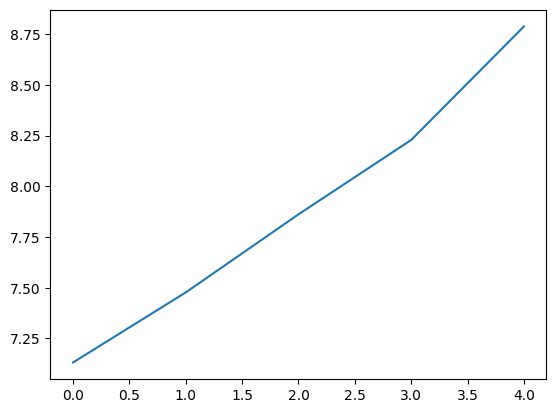

In [ ]:
import matplotlib as plt

pd.Series(obj_list).plot()